In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [14, 5]

In [5]:
data_ele_feature = pd.read_pickle("material_atomic_feature.pkl")
data = pd.read_csv("model_input.csv")
data_c = data.iloc[:104]
data_b = data.iloc[104:214]
data_a = data.iloc[214:308]
data_d = data.iloc[308:]

In [6]:
data_a.columns

Index(['A', 'B', 'O', 'bond_angle_a', 'bond_angle_c', 'cbm_diff', 'cbm_hse',
       'cbm_k_pbe', 'cbm_pbe', 'gap_diff', 'gap_hse', 'gap_pbe', 'material',
       'vbm_diff', 'vbm_hse', 'vbm_k_pbe', 'vbm_pbe'],
      dtype='object')

In [7]:
columns_include = ["material", "bond_angle_a", "bond_angle_c", "gap_diff", "vbm_diff", "cbm_diff", 'gap_hse']

In [8]:
data_a = pd.merge(data_a[columns_include], data_ele_feature, how='left', on = "material")
data_a["bond_angle_a"] = 180
data_a["bond_angle_c"] = 180
print("Size of data_a", data_a.shape)
# print(data_a.head())
data_b = pd.merge(data_b[columns_include], data_ele_feature, how='left', on = "material")
data_b["bond_angle_c"] = 180
print("Size of data_b", data_b.shape)
# print(data_b.head())
data_c = pd.merge(data_c[columns_include], data_ele_feature, how='left', on = "material")
print("Size of data_c", data_c.shape)
# print(data_c.head())
data_d = pd.merge(data_d[columns_include], data_ele_feature, how='left', on = "material")
print("Size of data_d", data_d.shape)
# print(data_d.head())

Size of data_a (94, 23)
Size of data_b (110, 23)
Size of data_c (104, 23)
Size of data_d (74, 23)


In [9]:
data_abcd = pd.concat([data_a, data_b, data_c, data_d], ignore_index=True)
data_abcd = data_abcd.drop("material", axis=1)
data_abcd

,bond_angle_a,bond_angle_c,gap_diff,vbm_diff,cbm_diff,gap_hse,Atomic mass_x,Atomic no_x,Atomic radius_x,Common oxidation states_x,X_x,outshell_orb_1_x,outshell_orb_2_x,Ion Energy_x,Atomic mass_y,Atomic no_y,Atomic radius_y,Common oxidation states_y,X_y,outshell_orb_1_y,outshell_orb_2_y,Ion Energy_y
0,180.000000,180.000000,1.2939,-0.9176,0.3763,2.5973,107.868200,47,1.60,1,1.93,-0.157407,-3.223090,7.5762,92.90638,41,1.45,5,1.60,-0.144272,-2.036693,6.7589
1,180.000000,180.000000,1.5968,-1.1740,0.4228,0.3264,107.868200,47,1.60,1,1.93,-0.157407,-3.223090,7.5762,121.76000,51,1.45,-3,2.05,-0.185623,-0.445605,8.6084
2,180.000000,180.000000,1.8259,-0.9627,0.8632,3.4342,107.868200,47,1.60,1,1.93,-0.157407,-3.223090,7.5762,180.94788,73,1.45,5,1.50,-0.174814,-0.182464,7.5496
3,180.000000,180.000000,0.7279,-0.8944,-0.1665,0.6300,107.868200,47,1.60,1,1.93,-0.157407,-3.223090,7.5762,50.94150,23,1.35,5,1.63,-0.175968,-2.526904,6.7462
4,180.000000,180.000000,1.7152,-0.8847,0.8305,1.4622,196.966569,79,1.35,3,2.54,-0.162334,-2.002495,9.2255,92.90638,41,1.45,5,1.60,-0.144272,-2.036693,6.7589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,135.593563,135.593563,1.5717,-0.9494,0.6223,4.2596,88.905850,39,1.80,3,1.22,-0.150727,-1.697124,6.2173,114.81800,49,1.55,3,1.78,-0.101782,-0.290497,5.7864
378,128.695147,128.695147,1.0824,-0.8026,0.2798,2.3649,88.905850,39,1.80,3,1.22,-0.150727,-1.697124,6.2173,204.38330,81,1.90,1,1.62,-0.101507,-0.285020,6.1082
379,143.615891,143.615891,1.9181,-1.2387,0.6794,3.7027,65.409000,30,1.35,2,1.65,-0.222725,-4.573041,9.3942,72.64000,32,1.25,-4,2.01,-0.426523,-0.149882,7.8994
380,142.348276,142.348276,1.5920,-0.9523,0.6397,3.9580,65.409000,30,1.35,2,1.65,-0.222725,-4.573041,9.3942,47.86700,22,1.40,4,1.54,-0.167106,-2.258007,6.8281


In [10]:
data_abcd[data_abcd.isnull().any(axis=1)]
data_abcd =data_abcd[data_abcd["gap_hse"]>0]
data_abcd.shape

(369, 22)

In [11]:
labels = ["cbm_diff", "vbm_diff", "gap_diff"]
X = data_abcd.drop(labels+["gap_hse", 'Atomic mass_x', 'Atomic mass_y'], axis=1).values
features = data_abcd.drop(labels+["gap_hse", 'Atomic mass_x', 'Atomic mass_y'], axis=1).columns

Predicting cbm_diff
mean_squared_error 0.0386 mean_absolute_error 0.105
mean_squared_error 0.0298 mean_absolute_error 0.102
mean_squared_error 0.0267 mean_absolute_error 0.0963
Averaged of 3 validations
mean_squared_error 0.0317 +/- 0.00501 mean_absolute_error 0.101 +/- 0.0036
Feature Importance: Index(['X_y', 'Ion Energy_y', 'bond_angle_a', 'outshell_orb_2_x',
       'Common oxidation states_y', 'bond_angle_c', 'outshell_orb_2_y',
       'Atomic no_x', 'outshell_orb_1_y', 'Atomic no_y', 'Atomic radius_x',
       'outshell_orb_1_x', 'Ion Energy_x', 'X_x', 'Atomic radius_y',
       'Common oxidation states_x'],
      dtype='object')
Predicting vbm_diff
mean_squared_error 0.0363 mean_absolute_error 0.101
mean_squared_error 0.026 mean_absolute_error 0.0776
mean_squared_error 0.0203 mean_absolute_error 0.0825
Averaged of 3 validations
mean_squared_error 0.0276 +/- 0.00663 mean_absolute_error 0.087 +/- 0.01
Feature Importance: Index(['X_x', 'outshell_orb_2_x', 'Ion Energy_y', 'bond_angle_a'

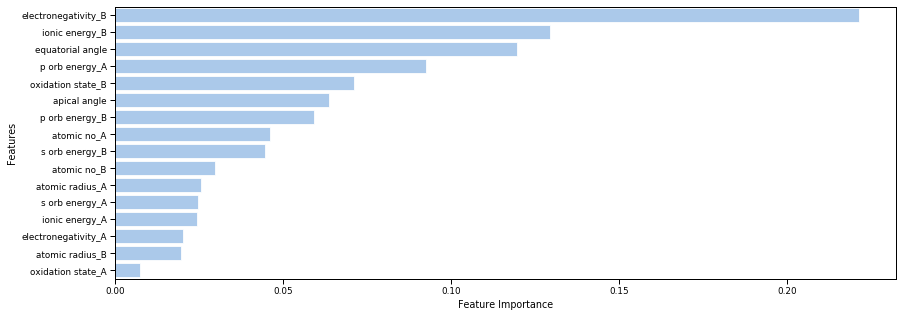

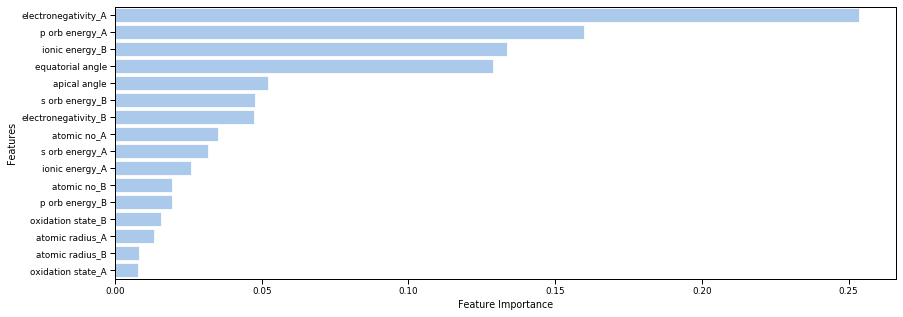

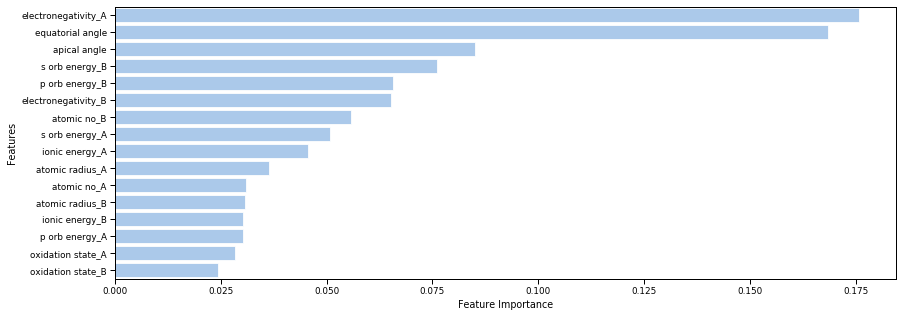

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

n_folds = 3
reg = GradientBoostingRegressor(max_depth=5, n_estimators=500)
skf = KFold(n_splits=n_folds, shuffle=True, random_state=1)
for label in labels:
    y = data_abcd[label].values
    mses, maes, feature_ranks = [], [], []
    print("Predicting", label)
    for train, test in skf.split(X, y):
        reg.fit(X[train], y[train])
        Y_test_pred = reg.predict(X[test])
        mse = mean_squared_error(y[test], Y_test_pred)
        mae = mean_absolute_error(y[test], Y_test_pred)
        mses.append(mse)
        maes.append(mae)
        feature_ranks.append(reg.feature_importances_)
        print("mean_squared_error", '{:.3}'.format(mse), "mean_absolute_error", '{:.3}'.format(mae))#, "Auc", test_auc)#, "Balanced Accuracy", test_accb)
    feature_rank = np.mean(feature_ranks, axis=0)
    print("Averaged of", n_folds, "validations")
    print("mean_squared_error", '{:.3}'.format(np.mean(mses)), "+/-", '{:.3}'.format(np.std(mses)), "mean_absolute_error", '{:.3}'.format(np.mean(maes)), "+/-", '{:.3}'.format(np.std(maes)))
    print("Feature Importance:", features[np.argsort(feature_rank)][::-1])
    feature_imp = pd.DataFrame({"Feature Importance": feature_rank, "Features":features})
    feature_imp["Features"] = feature_imp["Features"].str.replace('_x', '_A', regex=False)
    feature_imp["Features"] = feature_imp["Features"].str.replace('_y', '_B', regex=False)
    feature_imp["Features"] = feature_imp["Features"].str.replace('outshell_orb_1', 's orb energy', regex=False)
    feature_imp["Features"] = feature_imp["Features"].str.replace('outshell_orb_2', 'p orb energy', regex=False)
    feature_imp["Features"] = feature_imp["Features"].str.replace('Atomic', 'atomic', regex=False)
    feature_imp["Features"] = feature_imp["Features"].str.replace('X', 'electronegativity', regex=False)
    feature_imp["Features"] = feature_imp["Features"].str.replace('Ion Energy', 'ionic energy', regex=False)
    feature_imp["Features"] = feature_imp["Features"].str.replace('bond_angle_c', 'apical angle', regex=False)
    feature_imp["Features"] = feature_imp["Features"].str.replace('bond_angle_a', 'equatorial angle', regex=False)
    feature_imp["Features"] = feature_imp["Features"].str.replace('Common oxidation states', 'oxidation state', regex=False)
    plt.figure()
    sns.set_context('paper')
    feature_imp = feature_imp.sort_values('Feature Importance', ascending = False)
    sns.set_color_codes('pastel')
    sns.barplot(x = 'Feature Importance', y = 'Features', data = feature_imp,
                label = 'Feature Importance', color = 'b', edgecolor = 'w')
    plt.savefig('feature_ranking_' + label[:-5] + '.pdf', bbox_inches='tight')

In [13]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
reg = KernelRidge(kernel="poly", alpha=0.01)
skf = KFold(n_splits=3, shuffle=True, random_state=1)
for label in labels:
    y = data_abcd[label].values
    mses, maes, feature_ranks = [], [], []
    print("Predicting", label)
    for train, test in skf.split(X, y):
        scaler.fit(X[train])
        reg.fit(scaler.transform(X[train]), y[train])
        Y_test_pred = reg.predict(scaler.transform(X[test]))
        mse = mean_squared_error(y[test], Y_test_pred)
        mae = mean_absolute_error(y[test], Y_test_pred)
        mses.append(mse)
        maes.append(mae)
        print("mean_squared_error", '{:.3}'.format(mse), "mean_absolute_error", '{:.3}'.format(mae))
    print("Averaged of", n_folds, "validations")
    print("mean_squared_error", '{:.3}'.format(np.mean(mses)), "+/-", '{:.3}'.format(np.std(mses)), "mean_absolute_error", '{:.3}'.format(np.mean(maes)), "+/-", '{:.3}'.format(np.std(maes)))

Predicting cbm_diff
mean_squared_error 0.0575 mean_absolute_error 0.162
mean_squared_error 0.0354 mean_absolute_error 0.136
mean_squared_error 0.0576 mean_absolute_error 0.152
Averaged of 3 validations
mean_squared_error 0.0502 +/- 0.0104 mean_absolute_error 0.15 +/- 0.0107
Predicting vbm_diff
mean_squared_error 0.0241 mean_absolute_error 0.0848
mean_squared_error 0.0374 mean_absolute_error 0.0938
mean_squared_error 0.0134 mean_absolute_error 0.0768
Averaged of 3 validations
mean_squared_error 0.025 +/- 0.00979 mean_absolute_error 0.0851 +/- 0.00692
Predicting gap_diff
mean_squared_error 0.114 mean_absolute_error 0.222
mean_squared_error 0.0933 mean_absolute_error 0.203
mean_squared_error 0.0847 mean_absolute_error 0.188
Averaged of 3 validations
mean_squared_error 0.0974 +/- 0.0124 mean_absolute_error 0.204 +/- 0.0139


In [14]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
reg = KernelRidge(alpha=0.01)
skf = KFold(n_splits=3, shuffle=True, random_state=1)
for label in labels:
    y = data_abcd[label].values
    mses, maes, feature_ranks = [], [], []
    print("Predicting", label)
    for train, test in skf.split(X, y):
        scaler.fit(X[train])
        reg.fit(scaler.transform(X[train]), y[train])
        Y_test_pred = reg.predict(scaler.transform(X[test]))
        mse = mean_squared_error(y[test], Y_test_pred)
        mae = mean_absolute_error(y[test], Y_test_pred)
        mses.append(mse)
        maes.append(mae)
        print("mean_squared_error", '{:.3}'.format(mse), "mean_absolute_error", '{:.3}'.format(mae))
    print("Averaged of", n_folds, "validations")
    print("mean_squared_error", '{:.3}'.format(np.mean(mses)), "+/-", '{:.3}'.format(np.std(mses)), "mean_absolute_error", '{:.3}'.format(np.mean(maes)), "+/-", '{:.3}'.format(np.std(maes)))

Predicting cbm_diff
mean_squared_error 0.0781 mean_absolute_error 0.195
mean_squared_error 0.0597 mean_absolute_error 0.184
mean_squared_error 0.08 mean_absolute_error 0.185
Averaged of 3 validations
mean_squared_error 0.0726 +/- 0.00917 mean_absolute_error 0.188 +/- 0.00497
Predicting vbm_diff
mean_squared_error 0.0275 mean_absolute_error 0.0947
mean_squared_error 0.0426 mean_absolute_error 0.118
mean_squared_error 0.0189 mean_absolute_error 0.0933
Averaged of 3 validations
mean_squared_error 0.0297 +/- 0.00981 mean_absolute_error 0.102 +/- 0.0113
Predicting gap_diff
mean_squared_error 0.127 mean_absolute_error 0.248
mean_squared_error 0.124 mean_absolute_error 0.246
mean_squared_error 0.109 mean_absolute_error 0.213
Averaged of 3 validations
mean_squared_error 0.12 +/- 0.00767 mean_absolute_error 0.235 +/- 0.0161
